In [1]:
%load_ext autoreload
%autoreload 2

# Multicollinearity | All Variables

In [2]:
import sys
sys.path.append('../')
import tokamakTK

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
import plotly.subplots as plsp
import plotly.graph_objects as go

from sklearn.decomposition import PCA
from plotly.subplots import make_subplots
from tokamakTK import MyCounter, HUEOrder
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor


pd.set_option('display.max_columns', None)
plt.rc('font',family = 'serif')
TD_colors = plt.cm.get_cmap('flag', 20) #Paired, flag
colors_ = sns.color_palette('viridis', 20)
CSS_colors = [mcolors.to_hex(TD_colors(i)) for i in range(20)]
path = "../data/"

/tmp/ipykernel_6169/4012704369.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  TD_colors = plt.cm.get_cmap('flag', 20) #Paired, flag


In [3]:
# Obtained from Optimization
min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# REMOVING SPHERICAL TOKAMAKS
#DB5 = DB5[~DB5.TOK.isin(['MAST', 'NSTX', 'START'])]

# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.insert(loc=2,column="label_str",value=["Unaffected"]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label_str"] = "Decreasing"

print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

23.45% of the data decreased alpha_R
76.55% of the data did not decrease alpha_R


# Different subset of features with low VIF


```Python 

plasma_characteristics = ["QCYL5","BEIMHD","PREMAG","LHTIME","HYBRID",
                          "CONFIG","DWDIA","WMHD","TORQ","KAREA", "EPS","MEFF","VOL","LCOULOMB",
                          "IP","RHOSTAR","NUSTAR","BETASTAR"] 
TOK_characteristics = ["TOK","DIVNAME","WALMAT","DIVMAT","LIMMAT","AMIN","BT"]
ELM = ["ELMTYPE","ELMFREQ"]
heating = ["PECRH", "PICRH", "ICSCHEME","AUXHEAT","ECHMODE","PELLET"]
impurities = ["EVAP","ZEFF","ZEFFNEO","PRAD","POHM","ENBI","PNBI"]
power = ["PLTH","PFLOSS"]
temperatures = ["TAV","TEV","TIV"]
fast_particles = ["NESOL","WFFORM","WFICFORM","OMEGACYCL","NEL"] 

features = plasma_characteristics + TOK_characteristics + ELM + \
           heating + impurities + power + temperatures + fast_particles

```

In [4]:
# All below 5 VIF
features = ['AUXHEAT','BEIMHD','BETASTAR','BT','CONFIG','DIVMAT','DIVNAME','DWDIA',
            'ECHMODE','ELMFREQ','ELMTYPE','ENBI','EVAP','HYBRID','ICSCHEME','IP',
            'KAREA','LHTIME','LIMMAT','MEFF','NEL','NESOL','NUSTAR',
            'PECRH','PELLET','PFLOSS','PICRH','POHM','PRAD','PREMAG','Q95',
            'RHOSTAR','TAV','TIV','TOK','TORQ','WALMAT','WFFORM','WFICFORM',
            'ZEFF','ZEFFNEO'
           ]

# Removing due to high VIF
# PLTH(1302), AMIN(169), LCOULOMB(45), VOL(17), WMHD(11), TEV(7), EPS(7), OMEGACYCL(6), PNBI(7)


# PLTH with VIF ~ 5
features = ['NUSTAR', 'LHTIME', 'BETASTAR', 'Q95', 'HYBRID', 'BT', 'ENBI', 'POHM', 'TAV', 'RHOSTAR',
            'DWDIA', 'NEL', 'PFLOSS', 'KAREA', 'MEFF', 'WFICFORM', 'IP', 'PRAD', 'PICRH', 'PECRH']

"""# ENBI with VIF ~ 5
features =  ['NUSTAR', 'BETASTAR', 'Q95', 'HYBRID', 'ENBI', 'POHM', 'TAV', 'RHOSTAR', 'PRAD', 'LHTIME',
            'PNBI', 'DWDIA', 'BT', 'NEL', 'PFLOSS', 'KAREA', 'MEFF', 'WFICFORM', 'IP']""";

features = ['AUXHEAT','BETASTAR','BT','DIVNAME','ECHMODE','ELMFREQ','ELMTYPE',
            'ENBI','HYBRID','IP','KAREA','LHTIME','MEFF','NUSTAR','PECRH',
            'PELLET','PNBI','POHM','PREMAG','Q95','RHOSTAR',
            'TAV','TEV','TORQ','WFFORM','ZEFFNEO']

In [5]:
DB5 = tokamakTK.clean_categorical_data(DB5)


# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()


data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data = data_num.copy()#pd.concat([data_num, tokamakTK.encode_categorical_ohe(data_cat)], axis=1)

In [6]:
data.shape

(6252, 19)

## Correlation Matrix

A bivariate correlation of 0.8 or 0.9 is commonly used as a cut-ff to indicate a high correlation between two regressors. Nevertheless, high correlation does not imply multicollinearity, as they are not the same [[Chan, J. Y., et al, 2022]](https://doi.org/10.3390/math10081283). 

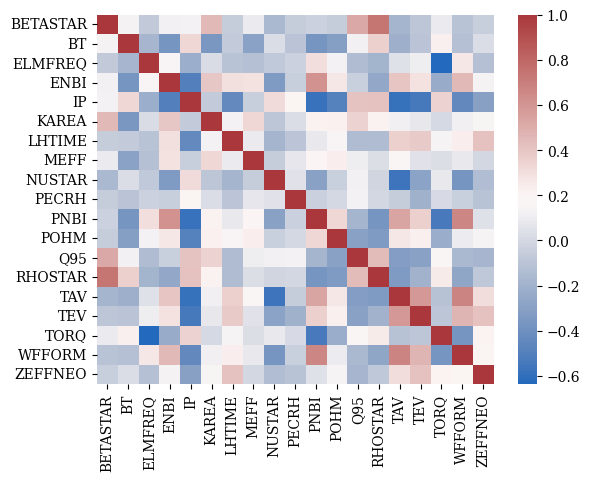

In [7]:
sns.heatmap(data.corr(), cmap="vlag", annot=False);

## Variance Inflation Factor (VIF) and Tolerance

The Variation Inflation Factor (VIF) is a measure of multicollinearity in a linear regression model. It quantifies the degree to which the variance of the estimated regression coefficient is inflated due to collinearity in the predictors.

"One recommendation is that **if VIF is greater than 5**, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this." [[statsmodels]](https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html)

$$
    \text{VIF}_j = \frac{1}{1-R^2_j}.
$$

With $R^2_j$ being the coefficient of determination for the regression of $x_j$ on the remaining variables; namely, 

$$
    R^2 = 1 - \frac{RSS}{TSS}.
$$

With $RSS$ being the sum of squares of residuals; and, $TSS$ the total sum of squares;

$$
    SSR = \sum_i\left( \hat{y} - \bar{y} \right)^2; \quad \text{and} \quad TSS = \sum_i\left( y - \bar{y} \right)^2
$$

**Tolerance** is the inverse of VIF and relates to the proportion of variance in a predictor variable. A **tolerance value less than 0.1** is generally considered to be indicative of problematic multicollinearity.

In [8]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = data.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data.values, col_indx) for col_indx in range(len(data.columns))]
vif_data["Tolerance"] = 1/vif_data["VIF"]
vif_data = vif_data.T; vif_data.columns = vif_data.iloc[0]; vif_data.drop("feature", inplace=True)

vif_data

feature,BETASTAR,BT,ELMFREQ,ENBI,IP,KAREA,LHTIME,MEFF,NUSTAR,PECRH,PNBI,POHM,Q95,RHOSTAR,TAV,TEV,TORQ,WFFORM,ZEFFNEO
VIF,4.204885,1.82983,1.825182,2.378019,3.494295,2.295903,1.687764,1.416635,1.860998,1.146061,3.683937,1.909047,2.033123,4.130886,4.117761,1.943435,2.598097,3.134875,1.539834
Tolerance,0.237819,0.546499,0.54789,0.420518,0.286181,0.435558,0.5925,0.705898,0.537346,0.872554,0.271449,0.523822,0.491854,0.242079,0.24285,0.514553,0.384897,0.318992,0.649421


In [9]:
vif_data.T[vif_data.T["VIF"] < 10 ]

,VIF,Tolerance
feature,,
BETASTAR,4.204885,0.237819
BT,1.82983,0.546499
ELMFREQ,1.825182,0.54789
ENBI,2.378019,0.420518
IP,3.494295,0.286181
KAREA,2.295903,0.435558
LHTIME,1.687764,0.5925
MEFF,1.416635,0.705898
NUSTAR,1.860998,0.537346


In [10]:
vif_data.T[vif_data.T["VIF"] >= 5 ]

,VIF,Tolerance
feature,,


In [11]:
vif_data.T[vif_data.T["VIF"] < 5 ].index

Index(['BETASTAR', 'BT', 'ELMFREQ', 'ENBI', 'IP', 'KAREA', 'LHTIME', 'MEFF',
       'NUSTAR', 'PECRH', 'PNBI', 'POHM', 'Q95', 'RHOSTAR', 'TAV', 'TEV',
       'TORQ', 'WFFORM', 'ZEFFNEO'],
      dtype='object', name='feature')

## Condition Index (or Condition Number)

Tthe ratio of the largest to the smallest eigenvalue of the correlation matrix. A condition number greater than 30 or 100 is often considered to be indicative of problematic multicollinearity.

In [12]:
#1. Compute the covatiance matrix of the data
cov = np.cov(data, rowvar=False)
#2. Get the eigenvalues of the covariance matrix.
eigenvals, _ = np.linalg.eig(cov)
#3. Compute the condition number

cond_num = max(eigenvals) / min(eigenvals)
print('Condition number:', cond_num)

Condition number: 43.473272564351205


In this case, the condition number is sligtly greater than 5, which indicates that there may be some degree of multicollinearity in the dataset; but, not severe 

## Exploratory Data Analysis

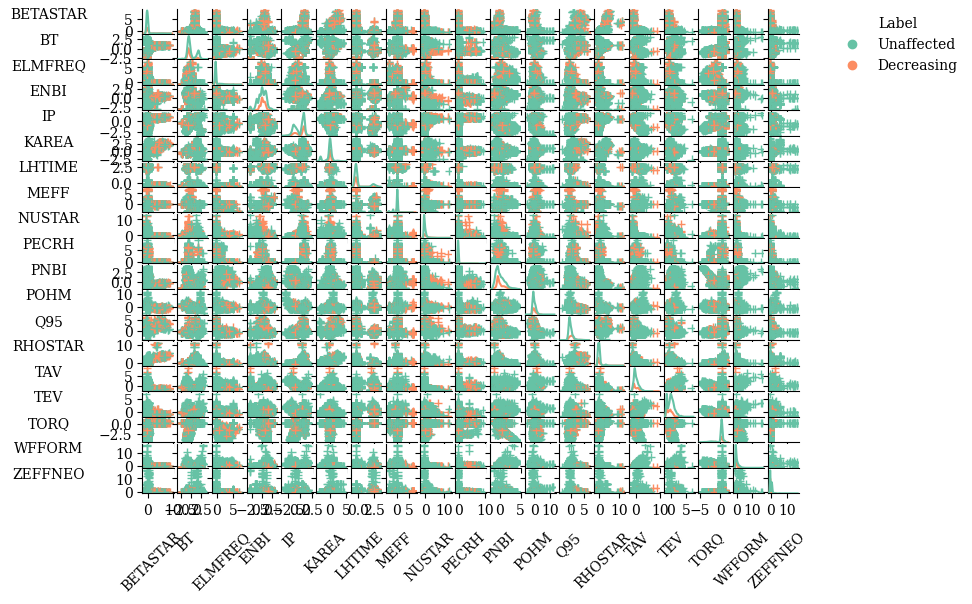

In [13]:
data["Label"] = DB5["label_str"]

g = sns.pairplot(data, 
             plot_kws=dict(marker="+", linewidth=1),
             diag_kws=dict(fill=False),
             hue="Label",
             palette="Set2"
            );
for ax in g.axes.flat:
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    ax.set_xlabel(ax.get_xlabel(), rotation = 45)
    ax.yaxis.set_label_coords(-3, 0.5)
    ax.xaxis.set_label_coords(0.3, -1.5)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
g.fig.set_size_inches(7,5)

## Principal Component Analysis (PCA)

In [14]:
#1. Standarize data: this is already done by tokamakTK
data = data.drop("Label", axis="columns")

#2. Perform the PCA
pca = PCA()
pca.fit(data)

#3. Examine the variance explained by each PC
variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(variance_ratio)

In [15]:
# Print the results
print("Variance explained by each PC:\n")
pd.DataFrame([variance_ratio], columns=data.columns, index=["Variance"]).T

Variance explained by each PC:



,Variance
BETASTAR,0.272232
BT,0.131286
ELMFREQ,0.113314
ENBI,0.084406
IP,0.061156
KAREA,0.046525
LHTIME,0.043700
MEFF,0.037140
NUSTAR,0.034335
PECRH,0.032519


In [16]:
print("Cumulative variance explained by each PC:\n")
pd.DataFrame([cumulative_variance_ratio], columns=data.columns, index=["Cum Variance"]).T

Cumulative variance explained by each PC:



,Cum Variance
BETASTAR,0.272232
BT,0.403518
ELMFREQ,0.516832
ENBI,0.601238
IP,0.662394
KAREA,0.708919
LHTIME,0.752619
MEFF,0.789759
NUSTAR,0.824095
PECRH,0.856614
